In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm

In [2]:
# load the SDSS dataset, stored in a json file. 
df0 = pd.read_json('Skyserver_SQL8_23_2021 12_55_36 PM.json')

In [3]:
df0.columns

Index(['TableName', 'Rows'], dtype='object')

In [4]:
df0['TableName']

0      Table1
1    SqlQuery
Name: TableName, dtype: object

In [5]:
df0['Rows']

0    [{'class': 'GALAXY', 'subClass': 'STARBURST', ...
1    [{'query': 'SELECT TOP 50000
s.class, s.subCl...
Name: Rows, dtype: object

In [6]:
# the data I care about are in df0[0,'Rows'], so I put them in a new dataframe that I wil use for the analysis
df = pd.DataFrame(df0.loc[0,'Rows'])
df.head()

,class,subClass,z,h_beta_flux,h_beta_flux_err,oiii_5007_flux,oiii_5007_flux_err,nii_6548_flux,nii_6548_flux_err,h_alpha_flux,h_alpha_flux_err,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,GALAXY,STARBURST,0.039029,162.07470,3.043153,174.23330,3.514477,42.705020,0.775339,633.89890,5.792587,18.28873,16.96553,16.44065,16.13555,15.98323
1,GALAXY,AGN BROADLINE,0.033373,82.98933,6.278155,114.62150,7.086028,149.892300,3.509799,329.22310,10.265790,16.88223,14.98691,14.18144,13.73065,13.37429
2,GALAXY,STARFORMING,0.032906,24.39114,2.144449,40.42598,2.447575,3.409367,0.456927,72.33459,2.022245,-9999.00000,-9999.00000,-9999.00000,-9999.00000,-9999.00000
3,GALAXY,STARBURST,0.033239,266.48680,3.893509,379.85480,4.786723,64.667410,0.866214,1103.61600,8.513324,18.39928,17.43055,16.90258,16.62180,16.39557
4,GALAXY,BROADLINE,0.032522,35.29839,5.658982,58.99754,5.785469,47.276790,2.512674,108.75120,7.780146,17.00099,15.39337,14.57772,14.20160,14.03099


In [7]:
# change the name of 'class' because the name 'class' would cause some problems later
df['Class'] = df['class']
df.drop(columns='class', inplace=True)

In [8]:
# need to eliminate data for which the u, b, r, i ,z mag are clearly wrong (i.e. -9999)
df.drop(df.loc[df['cModelMag_u']<0].index, inplace=True)
df.drop(df.loc[df['cModelMag_g']<0].index, inplace=True)
df.drop(df.loc[df['cModelMag_r']<0].index, inplace=True)
df.drop(df.loc[df['cModelMag_i']<0].index, inplace=True)
df.drop(df.loc[df['cModelMag_z']<0].index, inplace=True)

In [9]:
# eliminate also the data for which the u, g, r, i, z mag are above the threshold for secure detection
df.drop(df.loc[df['cModelMag_u']>22].index, inplace=True)
df.drop(df.loc[df['cModelMag_g']>22].index, inplace=True)
df.drop(df.loc[df['cModelMag_r']>22].index, inplace=True)
df.drop(df.loc[df['cModelMag_i']>22].index, inplace=True)
df.drop(df.loc[df['cModelMag_z']>22].index, inplace=True)

In [10]:
# drop those sources for which the subClass is unidentified
df.drop(df.loc[df['subClass']==''].index, inplace=True)

In [11]:
# construct new features: the colors (u-g, g-r, r-i, i-z)
df['u-g'] = df['cModelMag_u']-df['cModelMag_g']
df['g-r'] = df['cModelMag_g']-df['cModelMag_r']
df['r-i'] = df['cModelMag_r']-df['cModelMag_i']
df['i-z'] = df['cModelMag_i']-df['cModelMag_z']

In [12]:
# transform the categorical classed as category
df['Class'] = df['Class'].astype('category')
df['subClass'] = df['subClass'].astype('category')

In [13]:
# check the data types
df.dtypes

subClass              category
z                      float64
h_beta_flux            float64
h_beta_flux_err        float64
oiii_5007_flux         float64
oiii_5007_flux_err     float64
nii_6548_flux          float64
nii_6548_flux_err      float64
h_alpha_flux           float64
h_alpha_flux_err       float64
cModelMag_u            float64
cModelMag_g            float64
cModelMag_r            float64
cModelMag_i            float64
cModelMag_z            float64
Class                 category
u-g                    float64
g-r                    float64
r-i                    float64
i-z                    float64
dtype: object

In [14]:
# to have a grasp of the mutual Class-subClass relation, show the count in each Class, divided by subClasses
df.groupby(['Class','subClass']).z.count()

Class   subClass             
GALAXY  AGN                       2517
        AGN BROADLINE              317
        BROADLINE                  649
        STARBURST                11188
        STARBURST BROADLINE         18
        STARFORMING              28547
        STARFORMING BROADLINE      142
QSO     AGN                         85
        AGN BROADLINE              201
        BROADLINE                  938
        STARBURST                   26
        STARBURST BROADLINE       1230
        STARFORMING                 12
        STARFORMING BROADLINE       81
Name: z, dtype: int64

In [15]:
# explorative analysis: goals are two 
# - to classify the galaxies in classes and sub-classes
# - to develop a ML model that return the redshift
# Let's start from the CLASSIFICATION

In [16]:
df.subClass.value_counts()

STARFORMING              28559
STARBURST                11214
AGN                       2602
BROADLINE                 1587
STARBURST BROADLINE       1248
AGN BROADLINE              518
STARFORMING BROADLINE      223
Name: subClass, dtype: int64

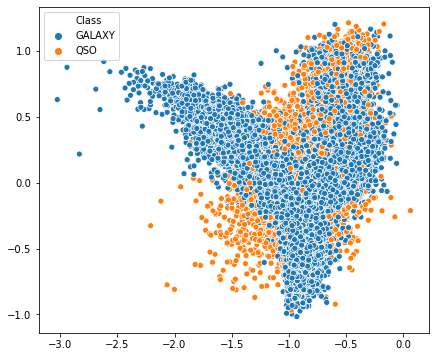

In [17]:
# astrophysical knowledge tell us that galaxies and qso are dislocated in different region in the BPT diagram
plt.figure(figsize=(7,6))
sns.scatterplot(y=np.log10(df['oiii_5007_flux']/df['h_beta_flux']), x=np.log10(df['nii_6548_flux']/df['h_alpha_flux']),
               hue='Class', data=df)

In [18]:
# given the aforementioned considerations let's add the two new features 'log_oiii_hbeta' and 'log_nii_halpha'
df['log_oiii_hbeta'] = np.log10(df['oiii_5007_flux']/df['h_beta_flux'])
df['log_nii_halpha'] = np.log10(df['nii_6548_flux']/df['h_alpha_flux'])

In [19]:
# plot the distribution of the various sources as a function of the colors, which may be also useful features
# to fine tune the classification

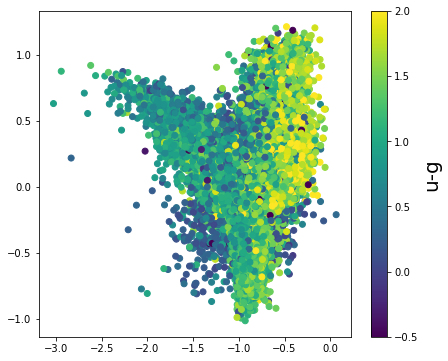

In [20]:
# u-g color (blue colors are characterized by low u-g values)
plt.figure(figsize=(7,6))
plt.scatter(np.log10(df['nii_6548_flux']/df['h_alpha_flux']), np.log10(df['oiii_5007_flux']/df['h_beta_flux']),
               c=df['u-g'], cmap=cm.viridis, vmin=-0.5, vmax=2.)
cb=plt.colorbar()
cb.set_label('u-g', size=20)

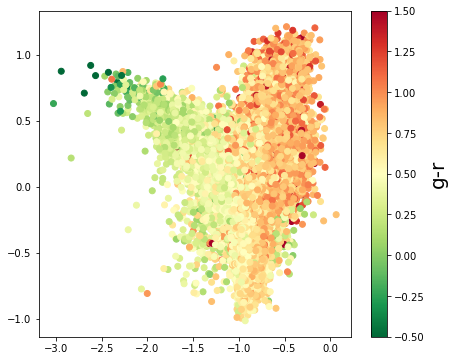

In [21]:
# g-r color (red colors are characterized by high g-r values)
plt.figure(figsize=(7,6))
plt.scatter(np.log10(df['nii_6548_flux']/df['h_alpha_flux']), np.log10(df['oiii_5007_flux']/df['h_beta_flux']),
               c=df['g-r'], cmap=cm.RdYlGn_r, vmin=-0.5, vmax=1.5)
cb=plt.colorbar()
cb.set_label('g-r', size=20)

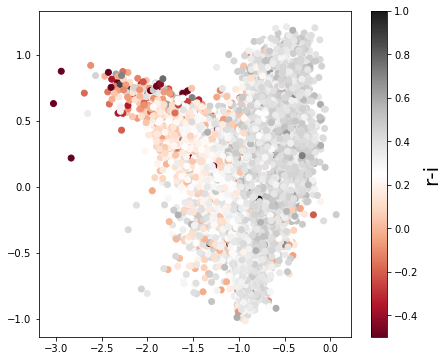

In [22]:
# r-i color, less conclusive
plt.figure(figsize=(7,6))
plt.scatter(np.log10(df['nii_6548_flux']/df['h_alpha_flux']), np.log10(df['oiii_5007_flux']/df['h_beta_flux']),
               c=df['r-i'], cmap=cm.RdGy, vmin=-0.5, vmax=1.)
cb=plt.colorbar()
cb.set_label('r-i', size=20)

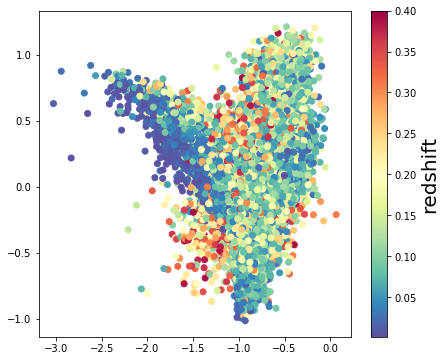

In [23]:
# let's also see whether the redshift can help discriminate the classes
plt.figure(figsize=(7,6))
plt.scatter(np.log10(df['nii_6548_flux']/df['h_alpha_flux']), np.log10(df['oiii_5007_flux']/df['h_beta_flux']),
               c=df['z'], cmap=cm.Spectral_r)
cb=plt.colorbar()
cb.set_label('redshift', size=20)

In [24]:
# the categorical columns in the pandas dataframe have codes associated
# which can be used as target for the classification, instead of the "name" of the class
print(df.subClass.cat.codes.unique())
print(df.subClass.unique())

[3 1 2 5 0 4 6]
[STARBURST, AGN BROADLINE, BROADLINE, STARFORMING, AGN, STARBURST BROADLINE, STARFORMING BROADLINE]
Categories (7, object): [STARBURST, AGN BROADLINE, BROADLINE, STARFORMING, AGN, STARBURST BROADLINE, STARFORMING BROADLINE]


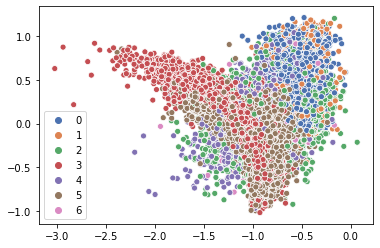

In [25]:
# this is just an example of using the cat codes instead of the names of the subclasses
sns.scatterplot(np.log10(df['nii_6548_flux']/df['h_alpha_flux']), np.log10(df['oiii_5007_flux']/df['h_beta_flux']),
               hue=df.subClass.cat.codes, palette='deep')

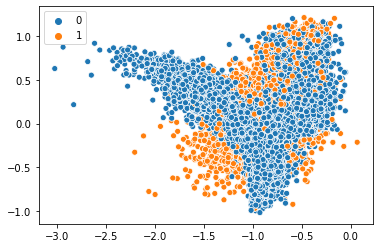

In [26]:
sns.scatterplot(np.log10(df['nii_6548_flux']/df['h_alpha_flux']), np.log10(df['oiii_5007_flux']/df['h_beta_flux']),
               hue=df.Class.cat.codes)

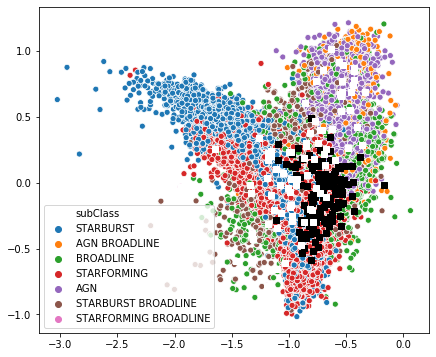

In [27]:
# from the astrophysics knowledge we know that some ratios are very helpful for distinguish the categories. Namely:
# oiii/hbeta and nii/halpha
plt.figure(figsize=(7,6))
sns.scatterplot(y=np.log10(df['oiii_5007_flux']/df['h_beta_flux']), x=np.log10(df['nii_6548_flux']/df['h_alpha_flux']),
               hue='subClass', data=df)

mask = np.logical_and(df['subClass'] == 'STARFORMING BROADLINE', df['Class'] == 'GALAXY')
plt.scatter(np.log10(df.loc[mask, 'nii_6548_flux']/df.loc[mask,'h_alpha_flux']),
            np.log10(df.loc[mask,'oiii_5007_flux']/df.loc[mask,'h_beta_flux']), marker='s', c='k')
mask = np.logical_and(df['subClass'] == 'STARFORMING BROADLINE', df['Class'] == 'QSO')
plt.scatter(np.log10(df.loc[mask, 'nii_6548_flux']/df.loc[mask,'h_alpha_flux']),
            np.log10(df.loc[mask,'oiii_5007_flux']/df.loc[mask,'h_beta_flux']), marker='s', c='w')

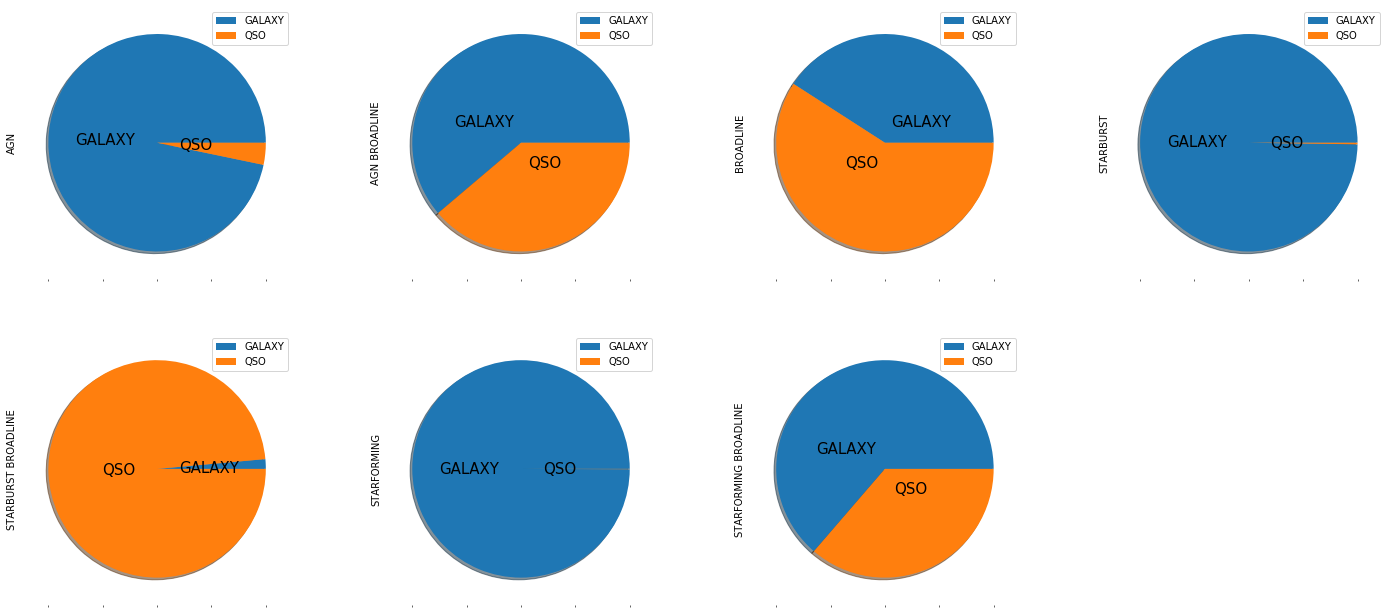

In [28]:
# breakout of the subclassification based on spectroscopy. For each sub-class the pies show the
# fraction of object photometrically defined as GALAXY and those defined as QSO.
df.groupby('Class').subClass.value_counts().unstack().plot.pie(subplots=True,
                                                               layout=(2,4),
                                                               figsize=(25,11),
                                                               labeldistance=0.2,
                                                               shadow=True,
                                                               fontsize=15)
plt.show()

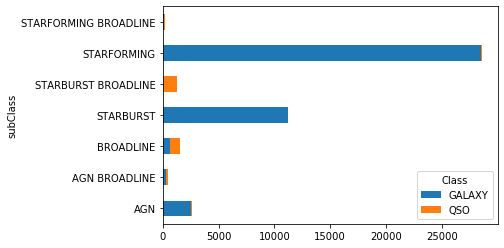

In [29]:
# there is clearly a class inbalance that will affect the performance of the classification algorithm.
# in particular the 'starforming broadline' are very very few and it is likely that they won't be classified very well
df.groupby('Class').subClass.value_counts().unstack(0).plot.barh(stacked=True)

In [30]:
# let now construct a classification model using two different methods:
#1) knn classifier
#2) random forest

In [31]:
# let's start from the knn classifier

In [32]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [33]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

In [34]:
# first add the only categorical feature, i.e. the class
Features = encode_string(df['Class'])
print(Features.shape)

(45951, 2)


In [35]:
# then add the other, numerical features
Features = np.concatenate([Features, 
                           np.array(df[['u-g', 'g-r', 'r-i', 'i-z', 'log_oiii_hbeta', 'log_nii_halpha', 'z']])], 
                           axis=1)
print(Features.shape)

(45951, 9)


In [36]:
# now set up the labels, which are the 7 possible classes for the SDSS objects
y = df['subClass'].cat.codes.values

In [37]:
# now tran test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, y, test_size=0.2, random_state=42)

In [38]:
# normalize the numerical features (i.e. all but the first one) with a MinMax scaler. 
# This must be fitted on the training dataset, and then applied
# also to the test.
# WARNING: MUST NOT be fitted to the whole dataset (train and test) together, otherwise there is
# information leakage that must be prevented.
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[:, 1:-1]) # <--- fitted on the train set only!!!
X_train[:, 1:-1] = scaler.transform(X_train[:, 1:-1])
X_test[:, 1:-1] = scaler.transform(X_test[:, 1:-1])

In [39]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (36760, 9) (36760,)
Test set: (9191, 9) (9191,)


In [40]:
# now perform the actual classification, without any further refinement (that will be done at a later stage)
# just default parameters
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
neigh

KNeighborsClassifier()

In [41]:
y_pred = neigh.predict(X_test)

In [42]:
# let's start evaluating the model
# let's import the confusion maxtrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(confusion)

Confusion matrix
[[ 416   11   30    1    2   66    0]
 [  41   20   13    0    8   10    1]
 [  58   15  174    1   81   18    2]
 [   2    0    2 1316    3  951    0]
 [   6    5   75    0  161    3    1]
 [  59    2    6  551    2 5041    0]
 [   3    1    4    0    6   23    0]]


In [43]:
# let's also retrieve the accuracy which, however, in this situation with multple classification
# is a pretty useless number
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.78



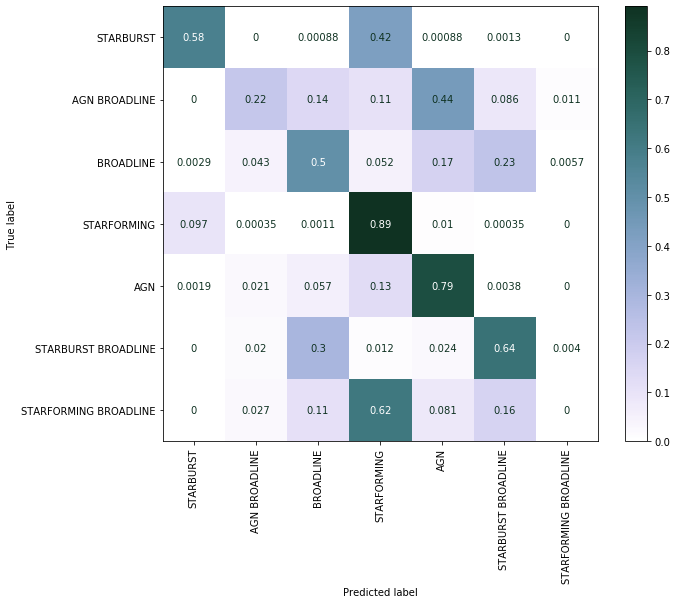

In [44]:
# note that for certain classes (starforming broadline, agn broadline) the performance is very poor
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)
plot_confusion_matrix(neigh, X_test, y_test, normalize='true', labels=np.array([3, 1, 2, 5, 0, 4, 6]), 
                      display_labels=df.subClass.unique(), cmap=cmap, xticks_rotation='vertical', ax=ax)
plt.show()

In [45]:
from sklearn.metrics import classification_report

**Precision**

Precision is the fraction of correctly classified label cases out of all cases classified with that label value. We can express precision by the following relationship:

$$Precision = \frac{TP}{TP + FP}$$

In other words, the precision statistic is **the number of correctly classified cases for the label value divided by all the cases classified with that label**. Thus, precision is sensitive to the number of cases correctly classified for a given score value. 

**Recall**  

Recall is the fraction of cases of a label value correctly classified out of all cases that actually have that label value. We can express recall by the following relationship:

$$Recall = \frac{TP}{TP + FN}$$

In other words, the recall statistic is **the number of correctly classified cases for the label value divided by the total number of cases that actually belong to the positive class**. Thus, recall is sensitive to the number of cases correctly classified for a given true label value. 

**F1**

The F1 statistic is weighted average of precision and recall. We can express F1 by the following relationship:

$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

In other words, F1 is a weighted metric for overall model performance. 

In [46]:
#Checking performance of the model with classification report.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       526
           1       0.37      0.22      0.27        93
           2       0.57      0.50      0.53       349
           3       0.70      0.58      0.64      2274
           4       0.61      0.64      0.63       251
           5       0.82      0.89      0.86      5661
           6       0.00      0.00      0.00        37

    accuracy                           0.78      9191
   macro avg       0.54      0.52      0.52      9191
weighted avg       0.77      0.78      0.77      9191



In [47]:
# let's first try to make an hyperparameter tuning to see whether the performance improve.
#Parameter tuning with GridSearchCV 
from sklearn.model_selection import GridSearchCV

estimator_KNN = KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'n_neighbors': (5, 10, 20),
    'leaf_size': (20,30, 40),}
grid = GridSearchCV(estimator_KNN, param_grid=parameters_KNN, cv=5, verbose=1, scoring='f1_macro')

In [48]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': (20, 30, 40), 'n_neighbors': (5, 10, 20)},
             scoring='f1_macro', verbose=1)

In [75]:
grid.best_params_

{'leaf_size': 20, 'n_neighbors': 20}

In [49]:
def plot_cv(clf, params_grid, param='n_neighbors'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys()) 
    keys = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
    gr = np.array([clf.cv_results_[key] for key in keys])
    means = np.mean(gr, axis = 0)
    stds = np.std(gr, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))

In [50]:
plot_cv(grid, parameters_KNN)

Performance metrics by parameter
Parameter   Mean performance   STD performance
    5.00        0.51596            0.00557
   10.00        0.53464            0.00397
   20.00        0.53666            0.00179


In [51]:
neigh = KNeighborsClassifier(leaf_size=20, n_neighbors=20)
neigh.fit(X_train, y_train)
neigh

KNeighborsClassifier(leaf_size=20, n_neighbors=20)

In [52]:
y_pred = neigh.predict(X_test)

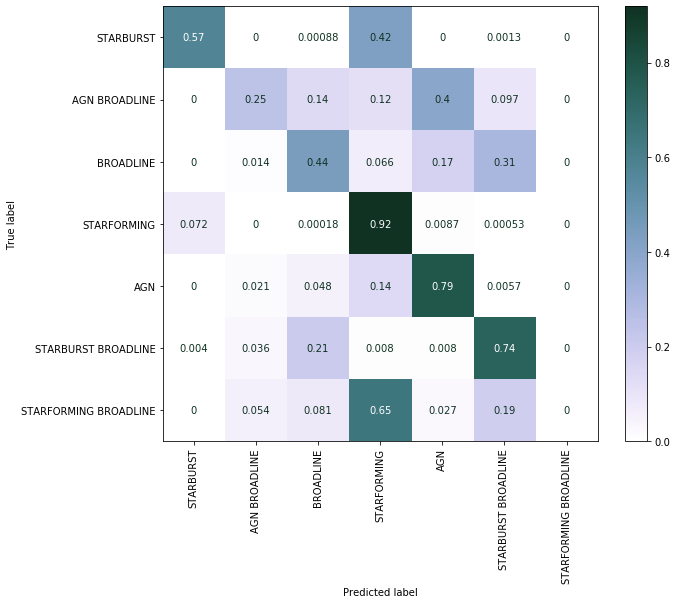

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)
plot_confusion_matrix(neigh, X_test, y_test, normalize='true', labels=np.array([3, 1, 2, 5, 0, 4, 6]), 
                      display_labels=df.subClass.unique(), cmap=cmap, xticks_rotation='vertical', ax=ax)
plt.show()

In [54]:
print(classification_report(y_test, y_pred, labels=np.array([3, 1, 2, 5, 0, 4, 6])))

              precision    recall  f1-score   support

           3       0.76      0.57      0.65      2274
           1       0.46      0.25      0.32        93
           2       0.62      0.44      0.52       349
           5       0.83      0.92      0.87      5661
           0       0.74      0.79      0.76       526
           4       0.58      0.74      0.65       251
           6       0.00      0.00      0.00        37

    accuracy                           0.79      9191
   macro avg       0.57      0.53      0.54      9191
weighted avg       0.78      0.79      0.78      9191



/anaconda2/envs/snakes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda2/envs/snakes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda2/envs/snakes/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# the model has slightly improved but there is still the huge issue with the completely missing
# classification of starforming - broadline that are never well classified as such.
# this likely arises from the very small number of occurences in this class, which has to be treated
# properly beforehand.
# one possibility is to switch to a tree-based algorithm (e.g. RandomForestClassifier) which perform better with 
# unbalanced datasets, let's try this possibility

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
# for random forest the minmax scaling of the numerical feature is actually not really important/required
# so I would use a set of Features (the same as before) but not scaled. Let's redefine them
#
# first add the only categorical feature, i.e. the class
Features = encode_string(df['Class'])
# then add the other, numerical features
Features = np.concatenate([Features, 
                           np.array(df[['u-g', 'g-r', 'r-i', 'i-z', 'log_oiii_hbeta', 'log_nii_halpha', 'z']])], 
                           axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(Features, y, test_size=0.2, random_state=42)

In [59]:
rfc = RandomForestClassifier(random_state=42)

In [60]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
y_pred = rfc.predict(X_test)

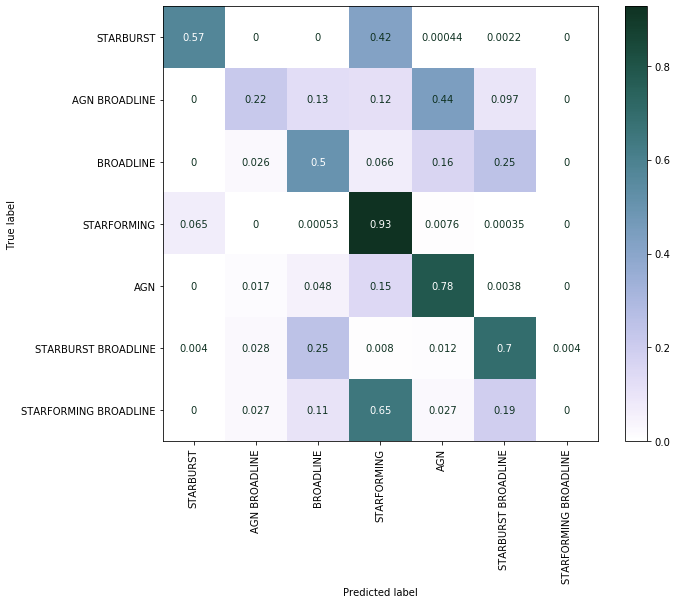

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)
plot_confusion_matrix(rfc, X_test, y_test, normalize='true', labels=np.array([3, 1, 2, 5, 0, 4, 6]), 
                      display_labels=df.subClass.unique(), cmap=cmap, xticks_rotation='vertical', ax=ax)
plt.show()

In [63]:
print(classification_report(y_test, y_pred, labels=np.array([3, 1, 2, 5, 0, 4, 6])))

              precision    recall  f1-score   support

           3       0.78      0.57      0.66      2274
           1       0.43      0.22      0.29        93
           2       0.62      0.50      0.56       349
           5       0.83      0.93      0.87      5661
           0       0.74      0.78      0.76       526
           4       0.61      0.70      0.65       251
           6       0.00      0.00      0.00        37

    accuracy                           0.80      9191
   macro avg       0.57      0.53      0.54      9191
weighted avg       0.79      0.80      0.79      9191



In [64]:
# the performance is slightly better than that obtained with the tuned KNN classifier 
# but there is still the big issue with the classification of starforming broadline galaxies which are basically
# classified as starforming. The issue is the small number of instances in this class so I need to implement
# some smart way to sample the unbalanced class, or weight it

In [66]:
rfc_bal = RandomForestClassifier(random_state=42, class_weight='balanced')

In [67]:
rfc_bal.fit(X_train, y_train)
y_pred = rfc_bal.predict(X_test)

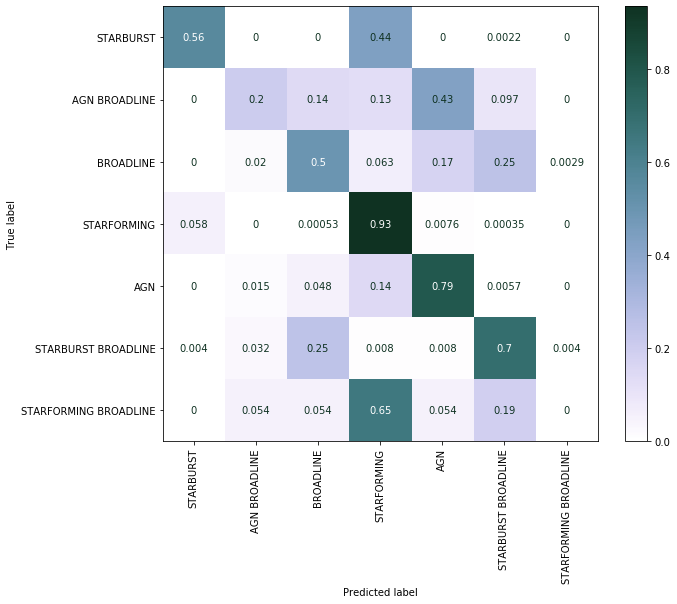

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)
plot_confusion_matrix(rfc_bal, X_test, y_test, normalize='true', labels=np.array([3, 1, 2, 5, 0, 4, 6]), 
                      display_labels=df.subClass.unique(), cmap=cmap, xticks_rotation='vertical', ax=ax)
plt.show()

In [69]:
print(classification_report(y_test, y_pred, labels=np.array([3, 1, 2, 5, 0, 4, 6])))

              precision    recall  f1-score   support

           3       0.80      0.56      0.66      2274
           1       0.43      0.20      0.28        93
           2       0.62      0.50      0.55       349
           5       0.82      0.93      0.88      5661
           0       0.74      0.79      0.76       526
           4       0.61      0.70      0.65       251
           6       0.00      0.00      0.00        37

    accuracy                           0.80      9191
   macro avg       0.57      0.53      0.54      9191
weighted avg       0.79      0.80      0.79      9191



In [70]:
# we now turn our attention on the possibility of over-sampling the minority class 
# or under-sampling the majority class.
# this can be done by using the imblearn library, that gathers several routines for dealing with unbalanced samples.

In [71]:
from imblearn.over_sampling import RandomOverSampler # this is for oversampling (randomly) the minority classes
from imblearn.under_sampling import ClusterCentroids # this instead is for undersampling (by using KNN means) the majority class

In [72]:
# let's first try the oversampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [73]:
rfc = RandomForestClassifier(random_state=42, min_samples_leaf=3, min_samples_split=5)
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=5, random_state=42)

In [74]:
y_pred = rfc.predict(X_test)

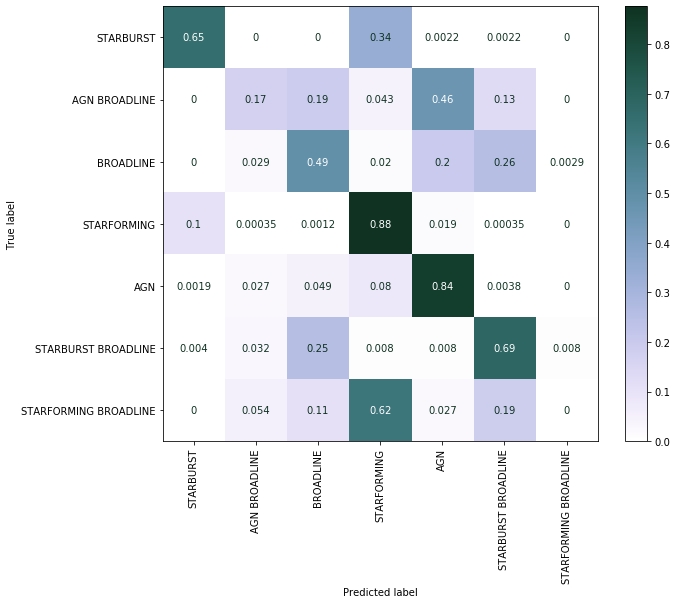

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)
plot_confusion_matrix(rfc, X_test, y_test, normalize='true', labels=np.array([3, 1, 2, 5, 0, 4, 6]), 
                      display_labels=df.subClass.unique(), cmap=cmap, xticks_rotation='vertical', ax=ax)
plt.show()

In [76]:
# let's now try the undersampler
cc = ClusterCentroids(random_state=42)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [77]:
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=5, random_state=42)

In [78]:
y_pred = rfc.predict(X_test)

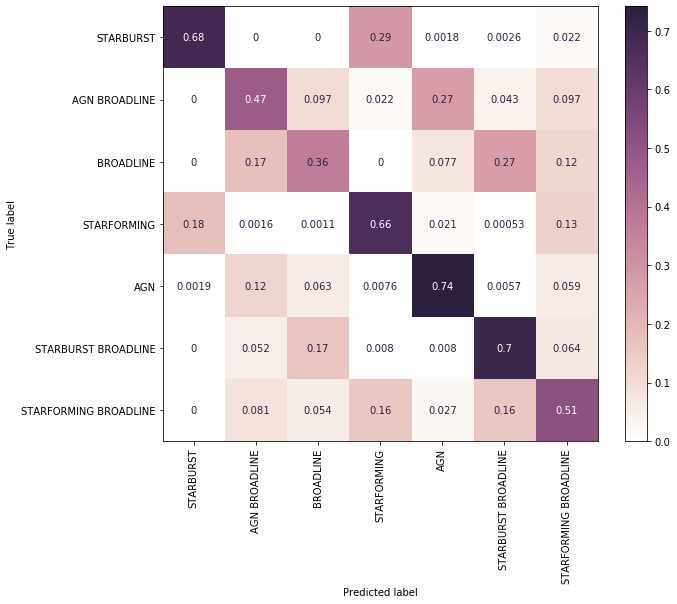

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
cmap = sns.cubehelix_palette(start=3, light=1, as_cmap=True)
plot_confusion_matrix(rfc, X_test, y_test, normalize='true', labels=np.array([3, 1, 2, 5, 0, 4, 6]), 
                      display_labels=df.subClass.unique(), cmap=cmap, xticks_rotation='vertical', ax=ax)
plt.show()

In [80]:
print(classification_report(y_test, y_pred, labels=np.array([3, 1, 2, 5, 0, 4, 6])))

              precision    recall  f1-score   support

           3       0.60      0.68      0.64      2274
           1       0.23      0.47      0.31        93
           2       0.58      0.36      0.45       349
           5       0.85      0.66      0.75      5661
           0       0.68      0.74      0.71       526
           4       0.60      0.70      0.65       251
           6       0.02      0.51      0.04        37

    accuracy                           0.66      9191
   macro avg       0.51      0.59      0.51      9191
weighted avg       0.75      0.66      0.70      9191



In [81]:
# one can then try to optimize the hyper parameters with gridsearch.
# note the GridSearchCV (where CV stands for Cross-Validation) is performed using cv=5
# this means that we use the default 5-fold cross validation with StratifiedKFold cross-validator.
# that is usually fine, but one can try different strategies by e.g. adopting different cross-validators.
#
# the main problem here is how to perform a CORRECT GridSearchCV with an unbalanced dataset, that has been undersampled
# with the help of the imblearn.
# the WRONG thing to do is: - to undersample and then split into cross validation folds
# the RIGHT thing to do is: - split into training and validation folds and THEN undersampling the majority class, 
#                             train the classifier on the training folds, validate the classifier on the remaining folds
# this is done by using the imblearn pipeline that takes care of everything (i.e. each step in the correct order).
# the whole thing is explained here: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
from imblearn.pipeline import Pipeline, make_pipeline

In [82]:
imba_pipeline = make_pipeline(ClusterCentroids(random_state=42), 
                              RandomForestClassifier(random_state=42))

params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 12],
    'random_state': [42]
}

new_params = {'randomforestclassifier__'+ key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=5, scoring='f1_macro',
                        return_train_score=True)


In [83]:
grid_imba.fit(X_train, y_train)

KeyboardInterrupt: 

In [121]:
grid_imba.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__random_state': 42}

In [122]:
y_pred = grid_imba.predict(X_test)

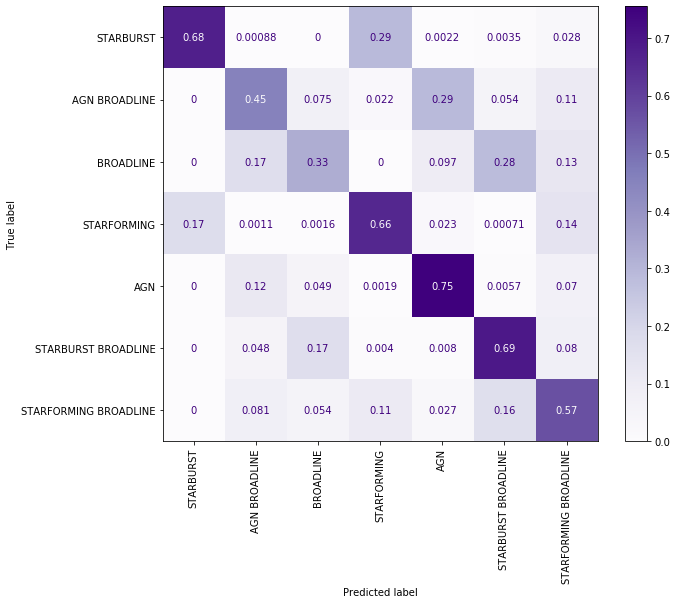

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
plot_confusion_matrix(grid_imba, X_test, y_test, normalize='true', labels=np.array([3, 1, 2, 5, 0, 4, 6]), 
                      display_labels=df.subClass.unique(), cmap=cm.Purples, xticks_rotation='vertical', ax=ax)
plt.show()

In [125]:
print(classification_report(y_test, y_pred, labels=np.array([3, 1, 2, 5, 0, 4, 6])))

              precision    recall  f1-score   support

           3       0.61      0.68      0.64      2274
           1       0.23      0.45      0.30        93
           2       0.57      0.33      0.42       349
           5       0.85      0.66      0.74      5661
           0       0.67      0.75      0.71       526
           4       0.58      0.69      0.63       251
           6       0.02      0.57      0.04        37

    accuracy                           0.66      9191
   macro avg       0.50      0.59      0.50      9191
weighted avg       0.75      0.66      0.69      9191

